# Setup

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from os import listdir

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [4]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False
    ):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if a legend is present.
        if ax.get_legend():
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()
    

In [78]:
df = pd.read_csv('data/modelling_data.csv', parse_dates=['DATETIME'], date_format='%Y-%m-%d %H:%M:%S')

states = ['NSW', 'QLD', 'SA', 'VIC']
df['state'] = df[states].idxmax(axis=1)

df


,TOTALDEMAND,TEMPERATURE,DATETIME,year,month,day_of_month,day_of_week,is_weekday,period_of_day,is_public_holiday,...,TM1200,TM1230,TM1260,TM1290,TM1320,TM1350,TM1380,TM1410,TM1440,state
0,7574.85,24.0,2010-01-02 00:00:00,2010,0.5,2,-0.974928,True,0.000000,False,...,6211.49,6282.85,6377.32,6544.33,6812.03,7117.23,7483.69,7809.31,8038.00,NSW
1,7343.30,24.3,2010-01-02 00:30:00,2010,0.5,2,-0.974928,True,0.130526,False,...,6248.31,6211.49,6282.85,6377.32,6544.33,6812.03,7117.23,7483.69,7809.31,NSW
2,7099.73,24.2,2010-01-02 01:00:00,2010,0.5,2,-0.974928,True,0.258819,False,...,6198.61,6248.31,6211.49,6282.85,6377.32,6544.33,6812.03,7117.23,7483.69,NSW
3,6779.80,24.2,2010-01-02 01:30:00,2010,0.5,2,-0.974928,True,0.382683,False,...,6237.35,6198.61,6248.31,6211.49,6282.85,6377.32,6544.33,6812.03,7117.23,NSW
4,6497.47,24.1,2010-01-02 02:00:00,2010,0.5,2,-0.974928,True,0.500000,False,...,6370.48,6237.35,6198.61,6248.31,6211.49,6282.85,6377.32,6544.33,6812.03,NSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785662,4625.28,16.8,2021-03-16 22:00:00,2021,1.0,16,0.781831,True,-0.500000,False,...,4039.09,4186.55,4308.17,4430.80,4611.25,4677.74,4508.23,4530.26,4627.82,VIC
785663,4532.19,16.3,2021-03-16 22:30:00,2021,1.0,16,0.781831,True,-0.382683,False,...,3985.33,4039.09,4186.55,4308.17,4430.80,4611.25,4677.74,4508.23,4530.26,VIC
785664,4484.89,16.0,2021-03-16 23:00:00,2021,1.0,16,0.781831,True,-0.258819,False,...,3907.27,3985.33,4039.09,4186.55,4308.17,4430.80,4611.25,4677.74,4508.23,VIC
785665,4711.26,15.6,2021-03-16 23:30:00,2021,1.0,16,0.781831,True,-0.130526,False,...,3918.31,3907.27,3985.33,4039.09,4186.55,4308.17,4430.80,4611.25,4677.74,VIC


# Temperature and total demand histograms
`

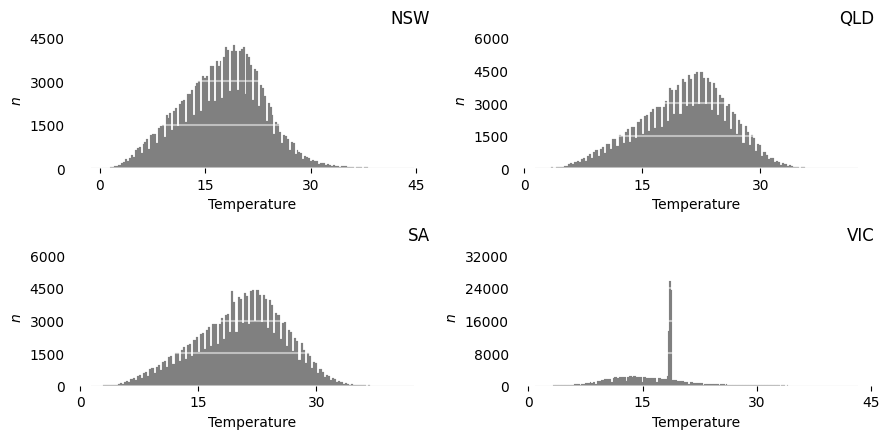

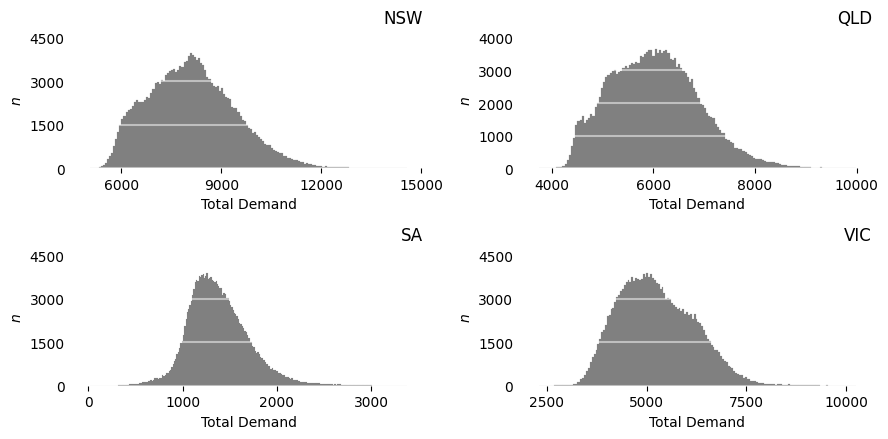

In [80]:
for col in ['Temperature', 'Total Demand']:
    fig, axes = plt.subplots(2, 2, figsize=(9, 4.5))
    axes = axes.flatten()
    col_label = col.replace(' ', '').upper()
    for i, state in enumerate(states):
        ax = axes[i]
        data = df[df.state==state]
        sns.histplot(data, x=col_label, color='grey', edgecolor='grey', alpha=1, ax=ax)
        
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        for line in ax.get_yticks():
            ax.axhline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)
        
        for side in ax.spines:
            ax.spines[side].set_visible(False)
        
        ax.tick_params(axis='y', color='white')
        ax.set_xlabel(col)
        ax.set_ylabel('$n$')
        ax.set_title(state, loc='right')
        
    show(fig, axes, file=f'{col} histogram', tight=True )


# Total demand vs. temperature


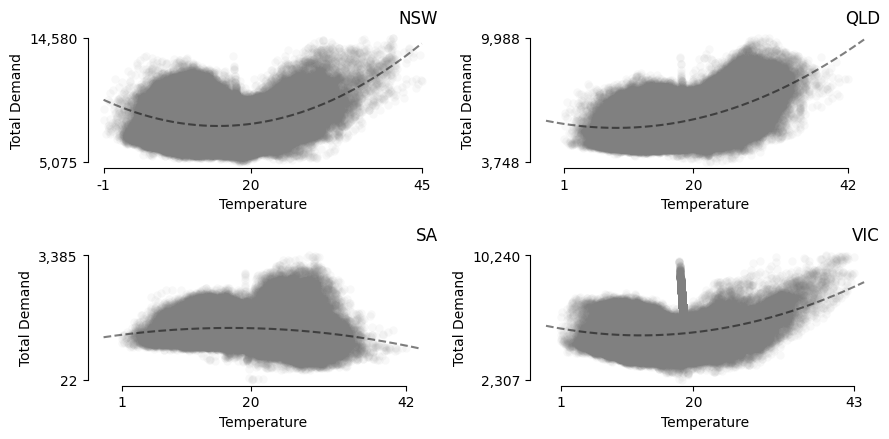

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(9, 4.5))
axes = axes.flatten()

for i, state in enumerate(states):
    data = df[df.state==state]
    dvt_model = ols("TOTALDEMAND ~ TEMPERATURE + I(TEMPERATURE**2)", data).fit()
    lobf_X = np.linspace(min(df.TEMPERATURE), max(df.TEMPERATURE), 1000)
    lobf_y =  dvt_model.predict(pd.Series(lobf_X, name='TEMPERATURE'))
        
    ax = axes[i]
    sns.scatterplot(
        data, y='TOTALDEMAND', x='TEMPERATURE', ax=ax,
        alpha=0.05, c='grey', lw=0, edgecolor='grey'
    )
    ax.plot(lobf_X, lobf_y, ls='--', c='black', alpha=.5)
    
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Total Demand')
    ax.set_title(state, loc='right')
    
    neaten_ticks(ax, 'x', [data.TEMPERATURE.min(), data.TEMPERATURE.max()], [20])
    neaten_ticks(ax, 'y', [data.TOTALDEMAND.min(), data.TOTALDEMAND.max()], [])
    
    ax.set_yticklabels([f"{e:,.0f}" for e in ax.get_yticks()])
    
show(fig, axes, True, file=f'Total demand vs. temperature scatterplot', filetype='png')


# Forecast demand histograms


In [91]:
fore = pd.read_csv('data/forecastdemand.csv', parse_dates=['LASTCHANGED', 'DATETIME'])

fore


,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,state
0,2016123041,48,6427.16,2016-12-31 00:01:03,2017-01-01 00:00:00,QLD
1,2016123042,48,6212.32,2016-12-31 00:31:05,2017-01-01 00:30:00,QLD
2,2016123043,48,6051.22,2016-12-31 01:01:06,2017-01-01 01:00:00,QLD
3,2016123044,48,5901.63,2016-12-31 01:31:06,2017-01-01 01:30:00,QLD
4,2016123045,48,5807.28,2016-12-31 02:01:06,2017-01-01 02:00:00,QLD
...,...,...,...,...,...,...
696414,2021031737,2,7316.62,2021-03-17 22:01:34,2021-03-17 23:00:00,NSW
696415,2021031640,48,7011.96,2021-03-16 23:31:34,2021-03-17 23:30:00,NSW
696416,2021031738,2,7187.72,2021-03-17 22:31:36,2021-03-17 23:30:00,NSW
696417,2021031641,48,6932.43,2021-03-17 00:01:34,2021-03-18 00:00:00,NSW


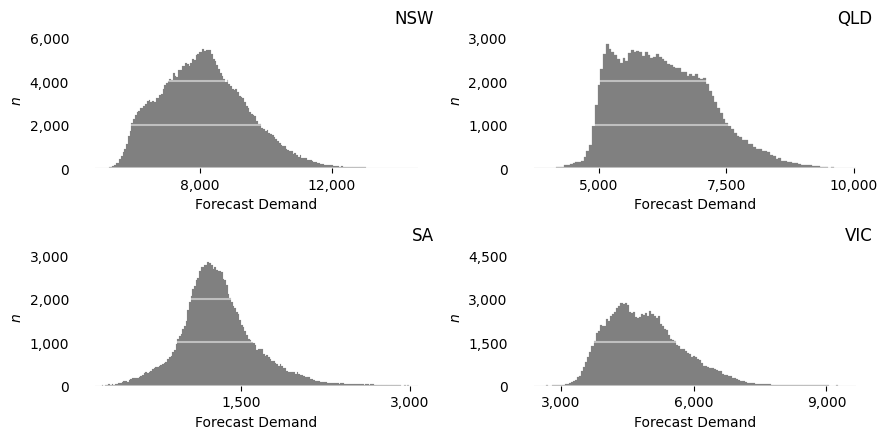

In [85]:
col_label = col.replace(' ', '').upper()
fig, axes = plt.subplots(2, 2, figsize=(9, 4.5))
axes = axes.flatten()

for i, state in enumerate(states):
    data = fore[fore.state==state]
    ax = axes[i]

    sns.histplot(data, x='FORECASTDEMAND', color='grey', edgecolor='grey', alpha=1, ax=ax)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    for line in ax.get_yticks():
        ax.axhline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)
        
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    
    for side in ax.spines:
        ax.spines[side].set_visible(False)
    
    ax.tick_params(axis='y', color='white')
    ax.set_xlabel('Forecast Demand')
    ax.set_ylabel('$n$')
    ax.set_title(state, loc='right')

show(fig, axes, True, file=f'Forecast demand histogram')


# Forecast vs. actual demand

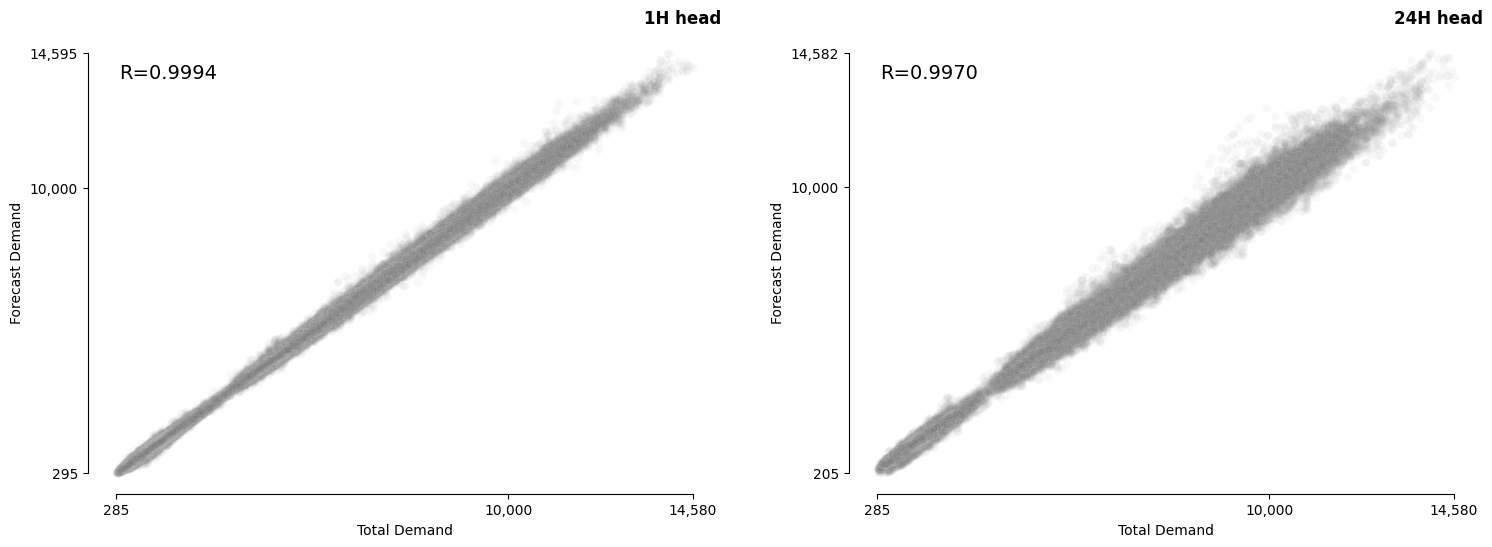

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes = axes.flatten()

hours_ahead = [2, 48]
for i, period in enumerate(hours_ahead):
    ax = axes[i]
    data = pd.merge(df, fore[fore.PERIODID == period][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
        .dropna().reset_index(drop=True)

    x, y ='TOTALDEMAND', 'FORECASTDEMAND'
    sns.scatterplot(data, x=x, y=y, ax=ax, alpha=0.05, c='grey')
    corr = pearsonr(data[x], data[y]).statistic
    ax.text(0.05, .9, f"R={corr:.04f}", transform=ax.transAxes, fontsize=14)
    
    ax.set_title(f"{period//2}H head", loc='right', fontweight=600)
    ax.set_xlabel('Total Demand')
    ax.set_ylabel('Forecast Demand')

    neaten_ticks(ax, 'x', [data.TOTALDEMAND.min(), data.TOTALDEMAND.max()], [1e4])
    neaten_ticks(ax, 'y', [data.FORECASTDEMAND.min(), data.FORECASTDEMAND.max()], [1e4])

    ax.set_xticklabels([f"{e:,.0f}" for e in ax.get_xticks()])
    ax.set_yticklabels([f"{e:,.0f}" for e in ax.get_yticks()])

show(fig, axes, file=f'Forecast vs. actual for 1- and 24-hours', legend_loc=0, filetype='png')



# Forecast vs.actual demand correlations by period ID

In [93]:
fore_full = pd.read_csv('data/forecastdemand_full.csv', parse_dates=['LASTCHANGED', 'DATETIME'])

fore_full


,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,state
0,2016123018,71,6425.36,2016-12-30 12:31:25,2017-01-01 00:00:00,QLD
1,2016123018,72,6193.34,2016-12-30 12:31:25,2017-01-01 00:30:00,QLD
2,2016123018,73,6016.45,2016-12-30 12:31:25,2017-01-01 01:00:00,QLD
3,2016123018,74,5859.23,2016-12-30 12:31:25,2017-01-01 01:30:00,QLD
4,2016123018,75,5767.15,2016-12-30 12:31:25,2017-01-01 02:00:00,QLD
...,...,...,...,...,...,...
23192506,2021031736,5,7028.45,2021-03-17 21:31:31,2021-03-18 00:00:00,NSW
23192507,2021031737,4,7041.65,2021-03-17 22:01:34,2021-03-18 00:00:00,NSW
23192508,2021031738,3,7087.60,2021-03-17 22:31:36,2021-03-18 00:00:00,NSW
23192509,2021031739,2,7087.28,2021-03-17 23:01:36,2021-03-18 00:00:00,NSW


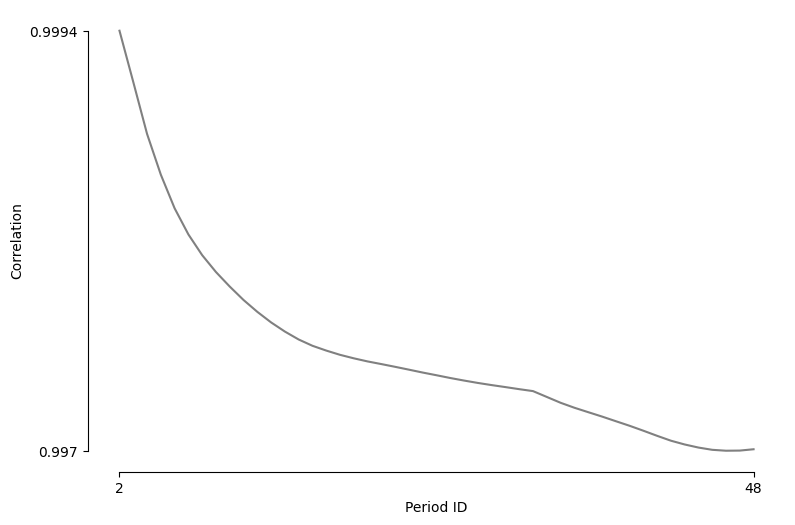

In [99]:
corrs = []
for i in range(min(hours_ahead), max(hours_ahead)+1):
    data = pd.merge(df, fore_full[fore_full.PERIODID == i][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
        .dropna().reset_index(drop=True)
    corr = pearsonr(data['TOTALDEMAND'], data['FORECASTDEMAND']).statistic
    corrs.append({'PERIODID': i, 'correlation': corr})

data = pd.DataFrame(corrs).sort_values('PERIODID')

fig, ax = plt.subplots(figsize=(9, 6))

data.plot(ax=ax, x='PERIODID', c='grey', alpha=1)

neaten_ticks(ax, 'x', [data.PERIODID.min(), data.PERIODID.max()], [])
neaten_ticks(ax, 'y', [data.correlation.min(), data.correlation.max()], [], dp=4)
ax.get_legend().remove()
ax.set_xlabel('Period ID')
ax.set_ylabel('Correlation')

show(fig, [ax], file=f'Forecast vs. actual correlation by Period ID', legend_loc=0)


# Demand by weekday and holiday quartile plots


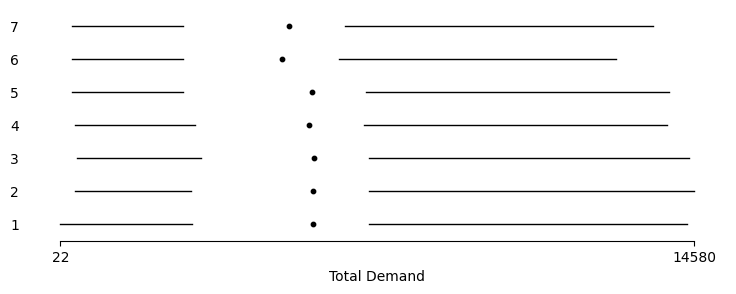

In [136]:
data = df.groupby(['day_of_week']).TOTALDEMAND.apply(list).sort_index(ascending=False)
medians = data.apply(np.median)

fig, ax = plt.subplots(figsize=(9, 3))

bplot = ax.boxplot(
    x=data, vert=False, showbox=False, #labels = [e[1] for e in data.index], 
    medianprops={'linewidth': 0}, whis=5, showcaps=False,
)
ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

ax.set_xlabel('Total Demand')

neaten_ticks(ax, 'x', [
    data.explode().to_frame().min().squeeze(), 
    data.explode().to_frame().max().squeeze()
], [])

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', left=False)

show(fig, [ax], file='Demand by day boxplots')


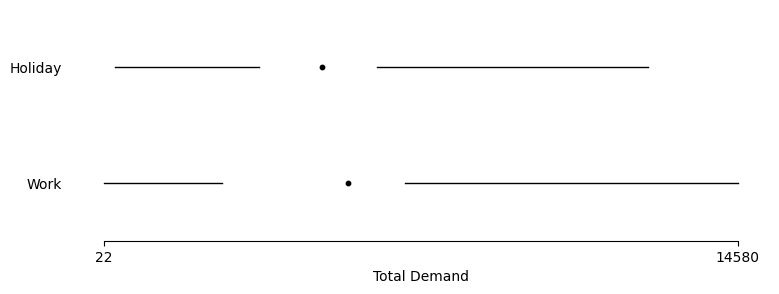

In [134]:
data = df.groupby('is_public_holiday').TOTALDEMAND.apply(list).sort_index()
medians = data.apply(np.median)

fig, ax = plt.subplots(figsize=(9, 3))

ax.boxplot(
    x=data, vert=False, labels = ['Holiday' if e else 'Work' for e in data.index], showbox=False,
    medianprops={'linewidth': 0}, whis=5, showcaps=False
)
ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

ax.set_xlabel('Total Demand')

neaten_ticks(ax, 'x', [
    data.explode().to_frame().min().squeeze(), 
    data.explode().to_frame().max().squeeze()
], [])

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', left=False)

show(fig, [ax], file='Demand by is-holiday boxplots')
